# Video Face Recognition (With FastAI V2)

In [1]:
from fastai2.vision.all import *

## Preparing the data

In [2]:
path = Path('./data/combined')
path

Path('data/combined')

In [3]:
files = get_image_files(path)
len(files)

1811

In [4]:
def label_func(file):
    return file.parent.name

label_func(files[0])

'dahyun'

In [5]:
dls = ImageDataLoaders.from_folder(path, item_tfms=Resize(224), num_workers=0)
print('Number of training images:', len(dls.train_ds.items))
print('Number of valid images:', len(dls.valid_ds.items))

Number of training images: 1480
Number of valid images: 331


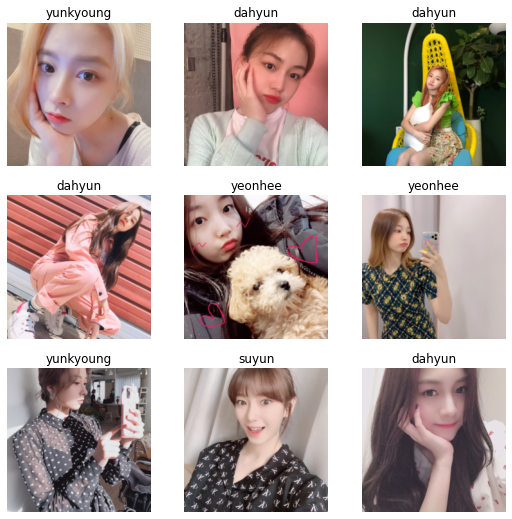

In [6]:
dls.show_batch()

In [7]:
parent_label(files[0])

'dahyun'

In [8]:
tcat = Categorize(vocab=['dahyun', 'juri', 'suyun', 'yeonhee', 'yunkyoung'])
lbl = tcat(parent_label(files[0]))
tcat.decode(lbl)

'dahyun'

## Train the model

In [9]:
learner = cnn_learner(dls, resnet34, metrics=[accuracy, error_rate])
learner.fine_tune(1)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,2.253626,1.452894,0.531722,0.468278,01:31


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.972749,1.014434,0.664653,0.335347,00:59


SuggestedLRs(lr_min=0.00012022644514217973, lr_steep=2.2908675418875646e-06)

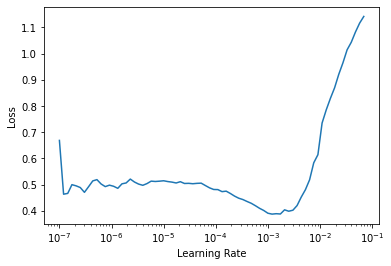

In [10]:
learner.lr_find()

In [11]:
learner.fine_tune(2, 2e-3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.490071,1.025204,0.703928,0.296073,00:59


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.349619,0.943291,0.725076,0.274924,01:00
1,0.247415,0.806330,0.761329,0.238671,01:00


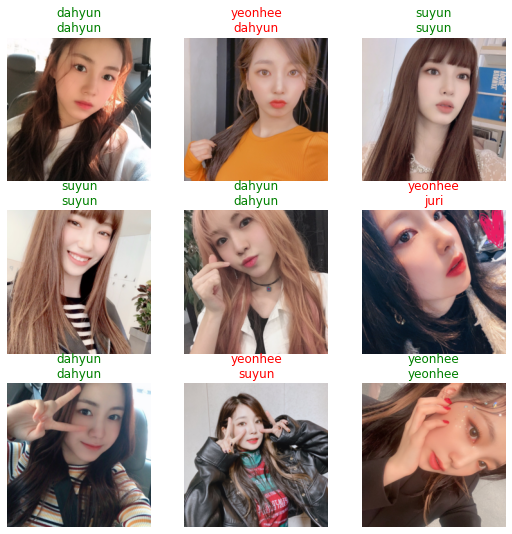

In [12]:
learner.show_results()

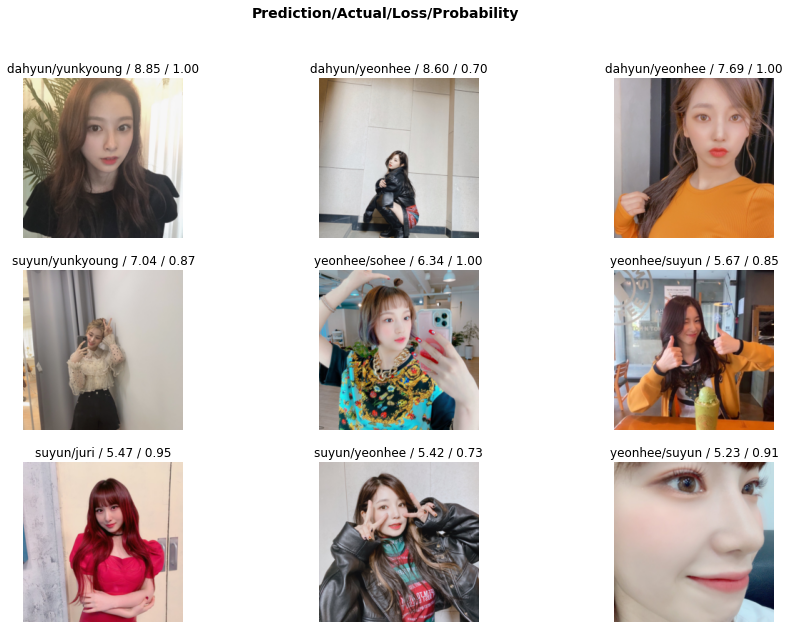

In [13]:
interp = Interpretation.from_learner(learner)
interp.plot_top_losses(9, figsize=(15,10))

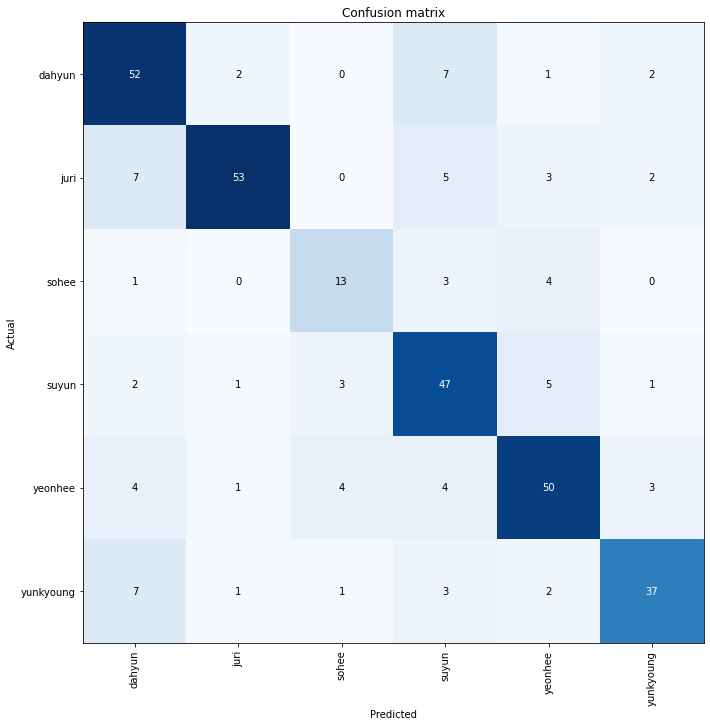

In [14]:
class_interp = ClassificationInterpretation.from_learner(learner)
class_interp.plot_confusion_matrix(figsize=(10,10))

dahyun


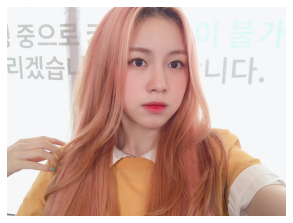

In [14]:
test_img = PILImage.create(files[0])
test_img.show()
pred, decoded_pred, full_pred = learner.predict(files[0])
print(pred)

In [15]:
learner.save('rcpc_face')

## Extract and predict faces

In [16]:
import cv2
import torch
import PIL

In [22]:
learn = learner.load('rcpc_face')

In [42]:
test_path = './data/combined/train'
test_images = get_image_files(test_path)
len(test_images)

1480

In [43]:
def convert_image(im, size=224):
    img = PIL.Image.open(fname).convert('RGB')
    img = im.resize((size, size))
    img_t = torch.Tensor(np.array(img))
    
    return img_t.permute(2,0,1).float()/255.

In [46]:
THRESHOLD = 0.5
RESIZE = 224

idx = 403
test_image = cv2.imread(str(test_images[idx]))

In [48]:
img_copy = test_image.copy()
proto_txt = './data/deploy.prototxt.txt'
caffe_model = './data/weights.caffemodel'

h, w = test_image.shape[:2]
blob = cv2.dnn.blobFromImage(img_copy, scalefactor=1.0, size=(300, 300), mean=(104.0, 177.0, 123.0), swapRB=False, crop=False)
face_model = cv2.dnn.readNetFromCaffe(proto_txt, caffe_model)
face_model.setInput(blob)
face_detector = face_model.forward()

if len(face_detector) > 0:
    for i in range(0, face_detector.shape[2]):
        rect = face_detector[0,0,i,3:7] * np.array([w,h,w,h])
        (startX, startY, endX, endY) = rect.astype('int')
        
        confidence = face_detector[0,0,i,2]
        if confidence >= THRESHOLD:
            cv2.rectangle(img_copy, (startX, startY), (endX, endY), (255,255,255), 2)
            
            face = img_copy[startY:endY, startX:endX]
            face = cv2.resize(face, (RESIZE, RESIZE))
            face = np.expand_dims(face, axis=0)
            m = 1
            c = 3
            face = np.reshape(face, [m, c, RESIZE, RESIZE])
            face = torch.Tensor(face)
#             print(face.shape)
            
            face = face.cuda()
            preds = learn.model(face)
            print(preds)
            label = tcat.decode(preds.argmax())
            print(label)
            e_x = np.exp(preds[0].cpu().detach().numpy())
            text = '{}: {:.2f}%'.format(label, np.max(e_x/e_x.sum()*100))
            cv2.putText(img_copy, text, (startX, startY-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
    
    cv2.imshow('Prediction', img_copy)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

tensor([[ 67.5693,  57.3011,  23.1235,  38.1416, -12.3090, -94.8889]],
       device='cuda:0', grad_fn=<MmBackward>)
dahyun


In [ ]:
def predict_from_video(path, learner):
    
    # load the video
    frame_name = 'Video'
    vid = cv2.VideoCapture(path) # video
    face_model = cv2.dnn.readNetFromCaffe(proto_txt, caffe_model)
    
    cv2.namedWindow(frame_name, cv2.WND_PROP_FULLSCREEN)
    cv2.setWindowProperty(frame_name, cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)
    
    # get video fps
    fps = vid.get(cv2.CAP_PROP_FPS)
    print('Video fps:', fps)
    
    while vid.isOpened():
        ret, frame = vid.read()
        (h,w) = frame.shape[:2]
        
        blob = cv2.dnn.blobFromImage(frame, scalefactor=1.0, size=(300, 300), mean=(104.0, 177.0, 123.0), swapRB=False, crop=False)
        face_model.setInput(blob)
        detector = face_model.forward()
        
        if len(detector) > 0:
            for i in range(0, detector.shape[2]):
                rect = detector[0, 0, i, 3:7] * np.array([w, h, w, h])
                (startX, startY, endX, endY) = rect.astype("int")

                confidence = detector[0, 0, i, 2]
                if (confidence >= THRESHOLD):
                    cv2.rectangle(frame, (startX, startY), (endX, endY), (255, 255, 255), 2)

                    face = frame[startY:endY, startX:endX]
                    if face.size == 0:
                        continue
                        
                    resized_face = cv2.resize(face, (RESIZE, RESIZE))
                    resized_face = np.expand_dims(resized_face, axis=0)

                    m = 1
                    c = 3
                    resized_face = np.reshape(resized_face, [m, c, RESIZE, RESIZE])
                    test_data = torch.Tensor(resized_face)
#                     test_data = test_data.cuda()

                    output = learner.model(test_data)
                    label = tcat.decode(output.argmax())
                    print(label)
                
                    cv2.putText(frame, label, (startX, startY-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
        
        if not ret:
            print('End of video...')
            break
            
        cv2.imshow(frame_name, frame)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    vid.release()
    cv2.destroyAllWindows()

In [ ]:
predict_from_video('data/videos/rcpc_loveisover_mcountdown.webm', learner)